In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
import boto3 
import pandas as pd 
import sagemaker
from sagemaker import get_execution_role 
# Define session, role, and region so we can
# perform any SageMaker tasks we need
sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = sagemaker_session.boto_region_name 

conn = boto3.client("s3") 

bucket = "retaildsbucket" 

import pandas as pd 

sales = pd.read_csv(f's3://{bucket}/{"Sales_Data.csv"}')
inventory = pd.read_csv(f's3://{bucket}/{"Inventory_Data.csv"}')
pricing = pd.read_csv(f's3://{bucket}/{"Competitor_Pricing_Data.csv"}')
behavior = pd.read_csv(f's3://{bucket}/{"Daily_Customer_Behavior.csv"}')

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


How does Tide’s discounting strategy affect actual sales volume and revenue?
* Do larger discounts always lead to higher units sold?
* Is there a “sweet spot” for discounting where revenue is maximized?

In [19]:
# Calculate Discount Percentage
sales['DiscountPercentage'] = (sales['MRP'] - sales['SellingPrice']) / sales['MRP'] * 100

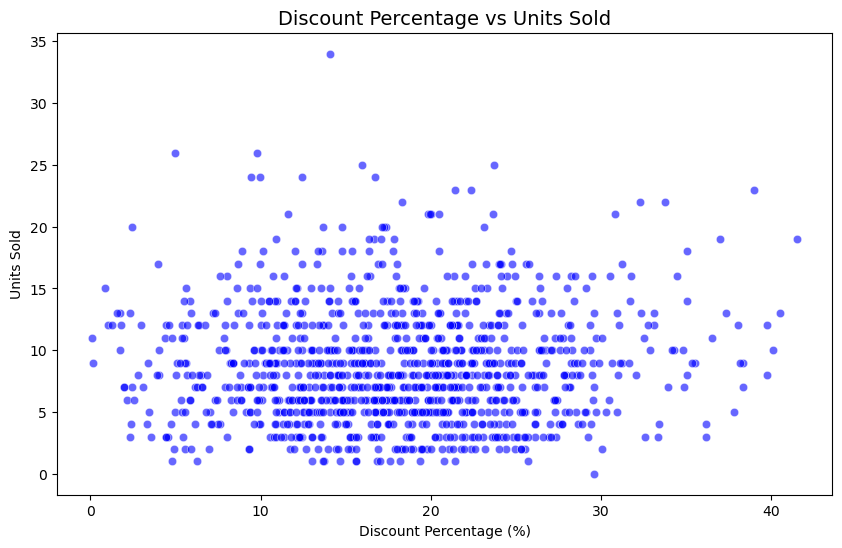

In [20]:
# Plot relationship between Discount Percentage and Units Sold
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sales, x='DiscountPercentage', y='UnitsSold', color='b', alpha=0.6)
plt.title('Discount Percentage vs Units Sold', fontsize=14)
plt.xlabel('Discount Percentage (%)')
plt.ylabel('Units Sold')
plt.show()

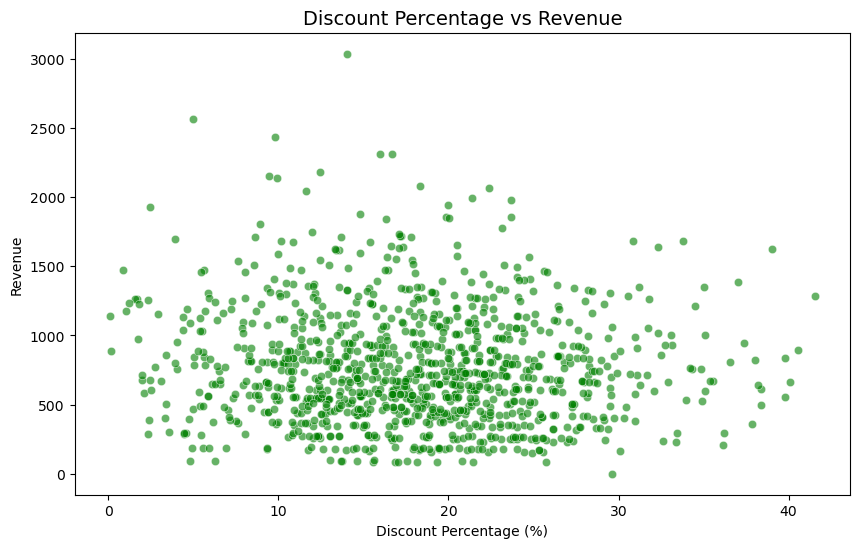

In [21]:
# Plot relationship between Discount Percentage and Revenue (Units Sold * Selling Price)
sales['Revenue'] = sales['UnitsSold'] * sales['SellingPrice']
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sales, x='DiscountPercentage', y='Revenue', color='g', alpha=0.6)
plt.title('Discount Percentage vs Revenue', fontsize=14)
plt.xlabel('Discount Percentage (%)')
plt.ylabel('Revenue')
plt.show()

In [22]:
# Calculate correlation coefficient between Discount Percentage and Units Sold
correlation_sales = sales['DiscountPercentage'].corr(sales['UnitsSold'])
correlation_revenue = sales['DiscountPercentage'].corr(sales['Revenue'])

correlation_sales, correlation_revenue

(0.04127325817804065, -0.07011640326709245)

Are sales being lost due to inventory stockouts at metro vs non-metro fulfillment centers?
* How often does demand exceed stock?
* Are metro centers facing higher backorders or missed opportunities?

In [23]:
# Calculate if demand exceeds stock (Stockouts)
inventory['Stockout'] = inventory['Demand'] > inventory['StockStart']

# Calculate Backorders (Demand - DemandFulfilled)
inventory['Backorders'] = inventory['Demand'] - inventory['DemandFulfilled']
inventory['MissedOpportunities'] = inventory['Backorders'] > 0

In [24]:
# Group data by FC_ID and IsMetro
stockout_summary = inventory.groupby(['FC_ID', 'IsMetro'])['Stockout'].mean().reset_index()
backorder_summary = inventory.groupby(['FC_ID', 'IsMetro'])['Backorders'].sum().reset_index()

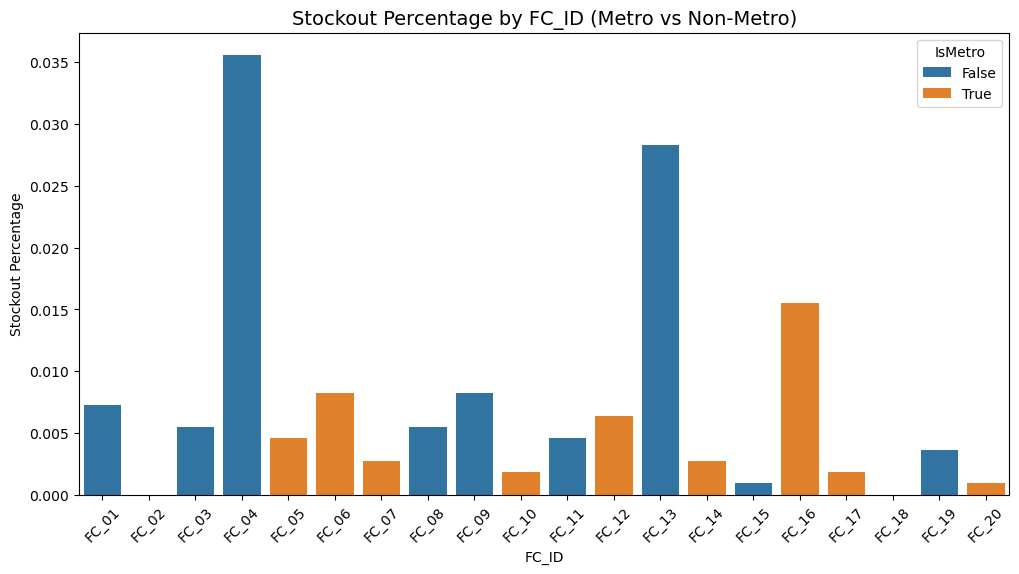

In [25]:
# Plotting
# Plot Stockout Percentage by FC_ID and Metro/Non-Metro
plt.figure(figsize=(12, 6))
sns.barplot(data=stockout_summary, x='FC_ID', y='Stockout', hue='IsMetro')
plt.title('Stockout Percentage by FC_ID (Metro vs Non-Metro)', fontsize=14)
plt.xlabel('FC_ID')
plt.ylabel('Stockout Percentage')
plt.xticks(rotation=45)
plt.show()

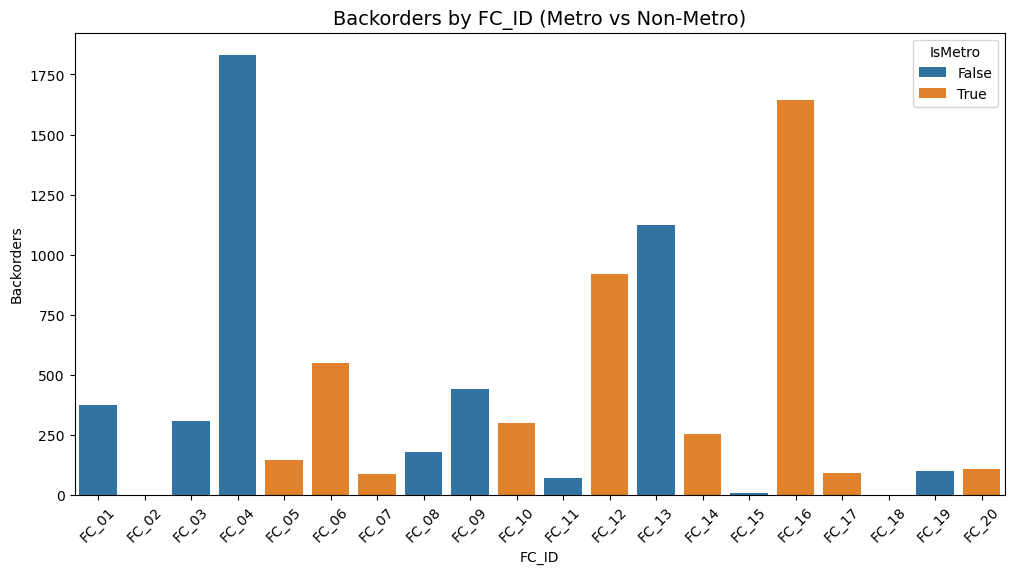

In [26]:
# Plot Backorders by FC_ID and Metro/Non-Metro
plt.figure(figsize=(12, 6))
sns.barplot(data=backorder_summary, x='FC_ID', y='Backorders', hue='IsMetro')
plt.title('Backorders by FC_ID (Metro vs Non-Metro)', fontsize=14)
plt.xlabel('FC_ID')
plt.ylabel('Backorders')
plt.xticks(rotation=45)
plt.show()

In [27]:
# Calculate the percentage of time stockout happened in metro vs non-metro centers
stockout_percentage = stockout_summary.groupby('IsMetro')['Stockout'].mean()
stockout_percentage

IsMetro
False    0.009954
True     0.004475
Name: Stockout, dtype: float64

Which competitor—Nirma or Surf Excel—has a stronger influence on Tide’s sales dips?
* On days when Tide sales dropped, were competitor prices lower?
* Is there a specific price gap that causes Tide sales to decline sharply?

In [28]:
import scipy.stats as stats

# Update the merge operation with the correct column names for date
merged_df = pd.merge(sales, pricing, left_on='TransactionDate', right_on='Date', how='left')

# Calculate the price difference (Tide - Competitor)
merged_df['PriceGap'] = merged_df['SellingPrice'] - merged_df['FinalPrice']

# Segment the data into when Tide has a higher price vs when competitor has a higher or equal price
higher_price_gap = merged_df[merged_df['PriceGap'] > 0]  # Tide is more expensive
lower_price_gap = merged_df[merged_df['PriceGap'] <= 0]  # Competitor is more expensive or equal

# Perform a t-test to compare the sales of Tide on days when the price gap is positive vs negative
t_stat, p_value = stats.ttest_ind(higher_price_gap['UnitsSold'], lower_price_gap['UnitsSold'])

# Display p-value for hypothesis testing
p_value


0.47390042909885033

In [29]:
# Re-import necessary libraries and load the datasets due to execution reset
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency


# Merge the sales data with competitor data on 'TransactionDate' and 'Date'
merged_df = pd.merge(sales, pricing, left_on='TransactionDate', right_on='Date', how='left')

# Merge with customer behavior data
merged_customer_sales_df = pd.merge(merged_df, behavior, left_on='TransactionDate', right_on='Date', how='left')

# Categorize BounceRate into low, medium, high categories based on quantiles or thresholds
bounce_rate_bins = [0, 0.2, 0.5, 1.0]
bounce_rate_labels = ['Low', 'Medium', 'High']
merged_customer_sales_df['BounceRateCategory'] = pd.cut(merged_customer_sales_df['BounceRate'], bins=bounce_rate_bins, labels=bounce_rate_labels)

# Categorize UnitsSold (sales) into low, medium, high categories based on quantiles or thresholds
sales_bins = [0, 10, 50, np.inf]  # Adjust these thresholds as needed
sales_labels = ['Low', 'Medium', 'High']
merged_customer_sales_df['SalesCategory'] = pd.cut(merged_customer_sales_df['UnitsSold'], bins=sales_bins, labels=sales_labels)

# Create the contingency table for BounceRateCategory vs SalesCategory
contingency_table = pd.crosstab(merged_customer_sales_df['BounceRateCategory'], merged_customer_sales_df['SalesCategory'])

# Perform the Chi-Square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Display the p-value for hypothesis testing
p_value, contingency_table


(0.04401789025414431,
 SalesCategory       Low  Medium
 BounceRateCategory             
 Low                  46      30
 Medium              380     134
 High                 96      42)

In [30]:

# Calculate Backorders (Demand - DemandFulfilled)
inventory['Backorders'] = inventory['Demand'] - inventory['DemandFulfilled']
inventory['StockAvailability'] = inventory['StockStart'] - inventory['Demand']

# Correlation between LeadTimeFloat and Backorders
correlation_leadtime_backorders = inventory['LeadTimeFloat'].corr(inventory['Backorders'])

# Group by FC_ID to calculate aggregates
report_df = inventory.groupby('FC_ID').agg({
    'LeadTimeFloat': 'mean',
    'Backorders': 'sum',
    'StockAvailability': 'mean',
    'Demand': 'mean'
}).reset_index()

# Calculate correlation between LeadTimeFloat and Backorders for each FC_ID
report_df['Correlation (Lead Time vs Backorders)'] = report_df.apply(
    lambda row: inventory[inventory['FC_ID'] == row['FC_ID']]['LeadTimeFloat'].corr(inventory[inventory['FC_ID'] == row['FC_ID']]['Backorders']),
    axis=1
)

# Group by FC_ID and IsMetro for additional comparison (metro vs non-metro)
metro_non_metro_report = inventory.groupby(['FC_ID', 'IsMetro']).agg({
    'LeadTimeFloat': 'mean',
    'Backorders': 'sum',
    'StockAvailability': 'mean',
    'Demand': 'mean'
}).reset_index()

In [31]:
report_df

,FC_ID,LeadTimeFloat,Backorders,StockAvailability,Demand,Correlation (Lead Time vs Backorders)
0,FC_01,7.18,373,3076.455708,63.900457,-1.747595e-16
1,FC_02,4.23,0,3515.415525,126.011872,NaN
2,FC_03,3.39,309,972.128767,63.788128,NaN
3,FC_04,2.21,1832,345.566210,63.961644,-1.162150e-16
4,FC_05,1.34,143,626.393607,131.116895,NaN
5,FC_06,0.30,547,270.478539,131.276712,NaN
6,FC_07,2.12,88,984.339726,128.966210,-2.461431e-16
7,FC_08,9.64,177,5002.901370,64.205479,-1.096540e-16
8,FC_09,4.95,441,1231.900457,63.000913,NaN
9,FC_10,4.44,297,2641.793607,127.394521,5.437497e-17


In [32]:
metro_non_metro_report

,FC_ID,IsMetro,LeadTimeFloat,Backorders,StockAvailability,Demand
0,FC_01,False,7.18,373,3076.455708,63.900457
1,FC_02,True,4.23,0,3515.415525,126.011872
2,FC_03,False,3.39,309,972.128767,63.788128
3,FC_04,False,2.21,1832,345.566210,63.961644
4,FC_05,True,1.34,143,626.393607,131.116895
5,FC_06,True,0.30,547,270.478539,131.276712
6,FC_07,True,2.12,88,984.339726,128.966210
7,FC_08,False,9.64,177,5002.901370,64.205479
8,FC_09,False,4.95,441,1231.900457,63.000913
9,FC_10,True,4.44,297,2641.793607,127.394521
